In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import recharge_funcs as rf
import baseflow
from pathlib import Path
import sys
import geopandas as gpd
from shapely.geometry import Point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#Scalable, Normalize
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as mticker
from sklearn.metrics import r2_score
import xarray as xr
#segoe UI
plt.rcParams['font.family'] = 'Segoe UI'

#### Model Evaluation
Seasonal comparison of discharge and baseflow

In [2]:
models = ["GFDL-ESM4", "IPSL-CM6A-LR", "MPI-ESM1-2-HR", "MRI-ESM2-0", "UKESM1-0-LL"]

#station coordinates
station_locations = pd.read_csv("mHM_eval_stations.csv")
#Boundaries data
be_shp = gpd.read_file(r"W:/VUB/_main_research/mHM/mhm_belgium/be_shp/be.shp")

#rivers
rivers_shp = gpd.read_file(r"W:/VUB/_main_research/data/shapefiles/HydroRIVERS_v10_eu_shp/HydroRIVERS_v10_eu_shp/hydroRivers_BE.shp")

#eval stations pickle path
base_dir = r"D:\VUB\_data\_isimip_3b\model_outputs"


#Open picked flow data for evaluation stations
with open(os.path.join(base_dir,"eval_stations_Q.pickle"), "rb") as f:
    eval_Obs = pickle.load(f)

#read validation stations (NSE>0) #from the flow_validation notebook
val_gdf = pd.read_csv('validation_stations_NSE_above_0.csv')

#Canals to be removed
canals = ['HACCOURT', 'Merendree_Afleidingskl Leie', 'Damme_Leopoldkl']

#Extract only stations in val_gdf
eval_Obs = {k: v for k, v in eval_Obs.items() if k in val_gdf['name'].values}

# Remove canal stations
eval_Obs = {k: v for k, v in eval_Obs.items() if k not in canals}

seasons = ['DJF', 'MAM', 'JJA', 'SON']

season_map = {12:"DJF",1:"DJF",2:"DJF",
            3:"MAM",4:"MAM",5:"MAM",
            6:"JJA",7:"JJA",8:"JJA",
            9:"SON",10:"SON",11:"SON"}

scenarios = ['historical', 'ssp370', 'ssp585']

##### Seasonal comparison of per-station Q

In [3]:
base_sim_dir = os.path.join(base_dir, "isimip_Q", "historical")

#Extract and seasonalize total discharge
model_seasons_df = rf.seasonal_Q_comparison(base_sim_dir, models, eval_Obs, season_map)


In [4]:
#extract multistation baseflow
eval_baseflow_models, eval_models_BFI, best_method = rf.extract_multistation_baseflow(base_sim_dir, models, eval_Obs)

Extracting baseflow for ZOUTLEEUW_KLEINE GETE                                                

In [5]:
ensemble_bf = pd.concat(
        [df.set_index('station') for df in eval_baseflow_models.values()],
        axis=0
    ).reset_index()

In [6]:
ens_mean_df = ensemble_bf.groupby(['station','model'])[['sim_Qb', 'obs_Qb']].mean().reset_index()

Text(0.5, 1.0, '(b)')

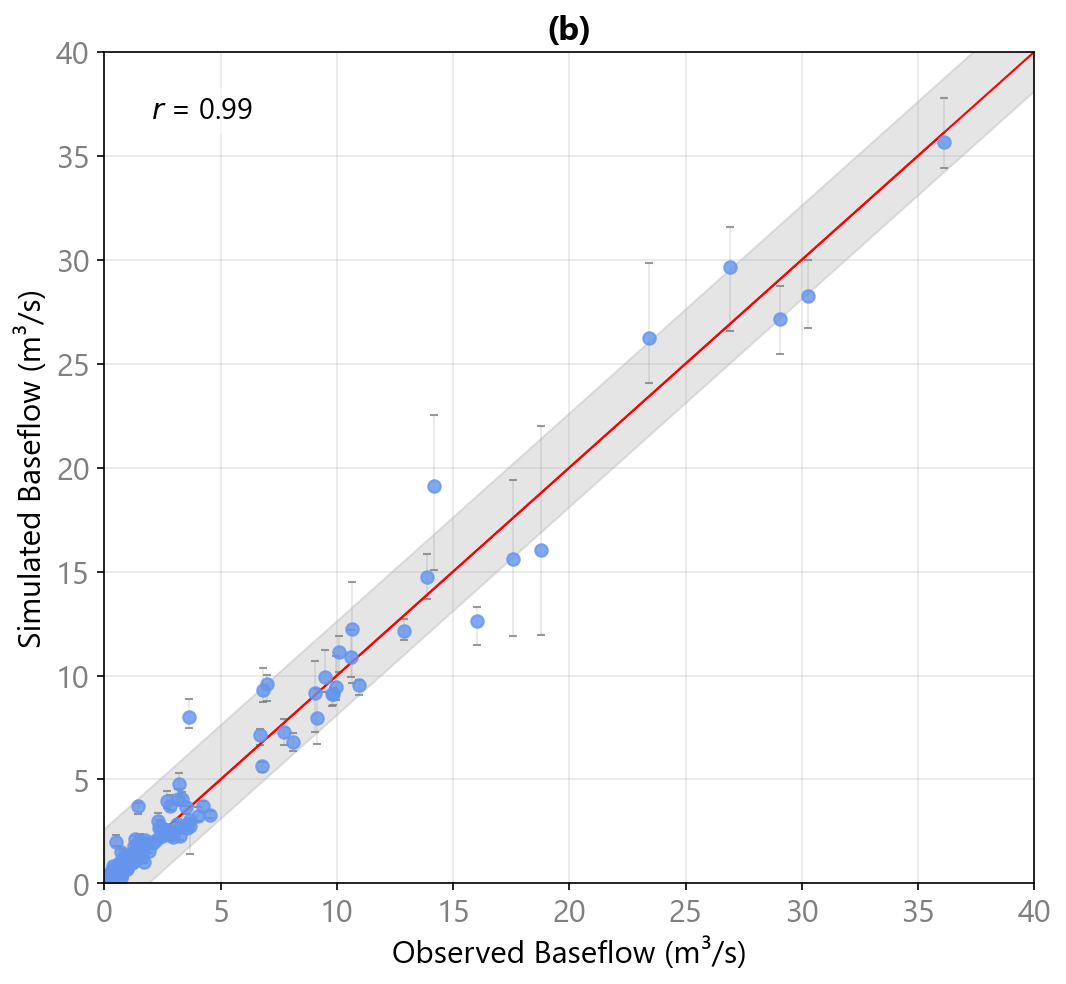

In [7]:
mean_sim_Qb = ens_mean_df[['station', 'sim_Qb']].groupby('station').mean(numeric_only=True)
max_sim_Qb = ens_mean_df[['station', 'sim_Qb']].groupby('station').max(numeric_only=True)
min_sim_Qb = ens_mean_df[['station', 'sim_Qb']].groupby('station').min(numeric_only=True)
x_obs = ens_mean_df[['station', 'obs_Qb']].groupby('station').mean(numeric_only=True)

#concatenate dfs
ens_stats_df = pd.concat([x_obs, mean_sim_Qb, min_sim_Qb, max_sim_Qb], axis=1).reset_index()
ens_stats_df.columns = ['station', 'obs_Qb', 'mean_sim_Qb', 'min_sim_Qb', 'max_sim_Qb']

ens_stats_df = ens_stats_df[ens_stats_df['obs_Qb'] < 100]

plt.figure(figsize=(8,7.2), dpi=150)
for station in ens_stats_df['station']:
    stat_x_obs = ens_stats_df.loc[ens_stats_df['station'] == station, 'obs_Qb'].values[0]
    mean_stat_sQb = ens_stats_df.loc[ens_stats_df['station'] == station, 'mean_sim_Qb'].values[0]
    min_stat_sQb = ens_stats_df.loc[ens_stats_df['station'] == station, 'min_sim_Qb'].values[0]
    max_stat_sQb = ens_stats_df.loc[ens_stats_df['station'] == station, 'max_sim_Qb'].values[0]

    plt.errorbar(
            stat_x_obs, mean_stat_sQb,
            yerr=[[mean_stat_sQb - min_stat_sQb], [max_stat_sQb - mean_stat_sQb]],
            fmt='o', color='cornflowerblue', markersize=6,
            alpha=0.8, capsize=2, ecolor='gray', elinewidth=0.2, capthick=1.0
        )

#compute R2
r2 = r2_score(ens_stats_df['obs_Qb'], ens_stats_df['mean_sim_Qb'])
r = np.corrcoef(ens_stats_df['obs_Qb'], ens_stats_df['mean_sim_Qb'])[0,1]


plt.plot([0, max(ens_stats_df['obs_Qb'].max(), ens_stats_df['mean_sim_Qb'].max())],
         [0, max(ens_stats_df['obs_Qb'].max(), ens_stats_df['mean_sim_Qb'].max())],
         color='r', label='1:1 line', linewidth=1.0)

plt.xlim(0, 40)
plt.ylim(0,40)

# residuals and 95PPU
residuals = ens_stats_df['mean_sim_Qb'] - ens_stats_df['obs_Qb']
lower = np.percentile(residuals, 2.5)
upper = np.percentile(residuals, 97.5)

# 1:1 line
lims = [0, 60]
plt.plot(lims, lims, 'r-', lw=1.0)

# 95PPU band
x_line = np.linspace(lims[0], lims[1], 200)
plt.fill_between(x_line, x_line + lower, x_line + upper,
                    color='gray', alpha=0.2, label='95PPU')


# annotate R² and P-factor on plot
plt.text(0.05, 0.92,
            f"$r$ = {r:.2f}",
            transform=plt.gca().transAxes,
            fontsize=14, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
plt.xticks(fontsize=15, c='gray')
plt.yticks(fontsize=15, c='gray')
plt.grid(alpha=0.3)
plt.xlabel("Observed Baseflow (m³/s)", fontsize=15, c='k')
plt.ylabel("Simulated Baseflow (m³/s)", fontsize=15, c='k')
plt.title('(b)', weight='bold', fontsize=16)


In [8]:
#seasonalize baseflow
Q_names = ['obs_Qb', 'sim_Qb'] #correspond to headers in baseflow_models
eval_seasonal_bf = rf.seasonal_baseflow_analysis(eval_baseflow_models, models, season_map, Q_names)

In [9]:
def plot_multimodel_spread(flow_df: dict, seasons: dict,
                           obs_name: str, sim_name: str,
                           xlabel: str,
                           ylabel: str):
    """
    Plot the spread of simulated vs observed baseflow for multiple models with 95PPU
    and compute the P-factor and R².
    """
    plt.figure(figsize=(8,7.5), dpi=120)

    all_obs = []
    all_mean_sim = []
    for season in seasons:
        for station in flow_df['name'].unique():
            q_sim_season = flow_df.loc[
                (flow_df['season'] == season) &
                (flow_df['name'] == station), sim_name]
            
            eval_Obs_season = flow_df.loc[
                (flow_df['season'] == season) &
                (flow_df['name'] == station), obs_name]

            mean_sim = q_sim_season.mean()
            min_sim = q_sim_season.min()
            max_sim = q_sim_season.max()
            x_obs = eval_Obs_season.mean()

            all_obs.append(x_obs)
            all_mean_sim.append(mean_sim)

            plt.errorbar(
                x_obs, mean_sim,
                yerr=[[mean_sim - min_sim], [max_sim - mean_sim]],
                fmt='o', color='cornflowerblue', markersize=8,
                alpha=0.8, capsize=2, ecolor='gray', elinewidth=0.9, capthick=1.2
            )

    # arrays
    all_obs = np.array(all_obs)
    all_mean_sim = np.array(all_mean_sim)

    # ---- Compute R² ----
    r2 = r2_score(all_obs, all_mean_sim)
    print(f"Coefficient of determination (R²): {r2:.2f}")

    # ---- Compute r ----
    r = np.corrcoef(all_obs, all_mean_sim)[0, 1]
    print(f"Correlation coefficient (r): {r:.2f}")

    # residuals and 95PPU
    residuals = all_mean_sim - all_obs
    lower = np.percentile(residuals, 2.5)
    upper = np.percentile(residuals, 97.5)

    # 1:1 line
    lims = [0, 60]
    plt.plot(lims, lims, 'r-', lw=1)

    # 95PPU band
    x_line = np.linspace(lims[0], lims[1], 200)
    plt.fill_between(x_line, x_line + lower, x_line + upper,
                     color='gray', alpha=0.2, label='95PPU')

    # ---- Compute P-factor ----
    inside = ((all_mean_sim >= all_obs + lower) & (all_mean_sim <= all_obs + upper))
    p_factor = inside.mean() * 100
    print(f"P-factor (percentage of points within 95PPU): {p_factor:.1f}%")

    # annotate R² and P-factor on plot
    plt.text(0.05, 0.92,
             f"$r$ = {r:.2f}",
             transform=plt.gca().transAxes,
             fontsize=14, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    
    #tick parameters
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    # axes, labels
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.grid(alpha=0.4)
    plt.show()

##### Comparison scatterplots

In [10]:
# plot_multimodel_spread(model_seasons_df, seasons,
#                        "q_obs", 'q_model',
#                        xlabel="Observed seasonal flow",
#                        ylabel="Simulated seasonal flow")

Coefficient of determination (R²): 0.76
Correlation coefficient (r): 0.92
P-factor (percentage of points within 95PPU): 94.9%


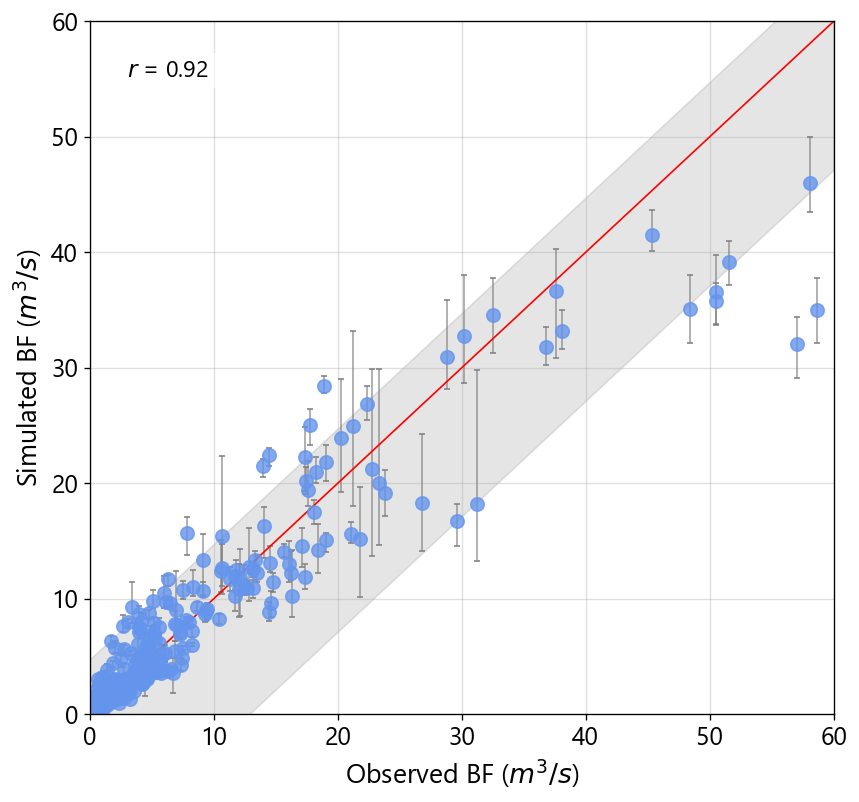

In [11]:
plot_multimodel_spread(eval_seasonal_bf, seasons,
                       'obs_Qb', 'sim_Qb',
                       xlabel="Observed BF ($m^3/s$)",
                       ylabel="Simulated BF ($m^3/s$)")

In [12]:
ensemble_bfi_df=rf.ensemble_station_BFI(eval_models_BFI, 'sim_bfi')

In [13]:
def map_BFI_anomalies(bfi_gdf, boundaries_shp, streams_shp, m_diff, p_w):

    """ 
    Map differences between obs. and sim. BFI per station overlain over a map and river network
    ------
    Parameters:
    bfi_gdf:
    Geodataframe containing obs-sim BFI, station names and coordinates
    boundaries_shp:  
    Boundary of domain
    streams_shp:
    river network
    m_diff, p_w: 
    wilcoxon stats above

    -----
    Returns:
    map of sim-obs. BFI per station and histogram of error distribution
    
    """

    fig, ax = plt.subplots(figsize=(15, 7), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)

    boundaries_shp.plot(ax=ax, linewidth=0.5,
                edgecolor='black', facecolor='none', zorder=1, transform=ccrs.PlateCarree())

    streams_shp.plot(ax=ax, linewidth=0.5, alpha=0.2,
                    edgecolor='dodgerblue', facecolor='none', zorder=2, transform=ccrs.PlateCarree())


    diff = bfi_gdf['bfi_diff'].to_numpy()

    # color: diverging, centered at 0
    vmax = np.nanpercentile(np.abs(diff), 99)  # robust limits
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
    cmap = 'coolwarm'  # blue = negative, red = positive (reverse if you prefer)

    # size: scale |diff| to [smin, smax]
    mag = np.abs(diff)
    smin, smax = 30, 300
    sizes = np.interp(mag, [mag.min(), mag.max()], [smin, smax])


    sc = ax.scatter(
        bfi_gdf.geometry.x, bfi_gdf.geometry.y,
        c=diff,
        s=70,
        cmap=cmap,
        edgecolor='white',
        linewidth=0.5,
        transform=ccrs.PlateCarree(),
        zorder=3,
    )
    ax.set_title('(a)', weight='bold', fontsize=16)
    gl = ax.gridlines(draw_labels=True, color='gray', lw=0.6, alpha=0.2)
    gl.xlocator = plt.FixedLocator(np.arange(0, 10, 1))
    gl.ylocator = plt.FixedLocator(np.arange(49.5, 51.9, 0.4))
    gl.top_labels = True
    gl.bottom_labels = False
    gl.right_labels = False
    #labelsize
    gl.xlabel_style = {'size': 14, 'color': 'gray'}
    gl.ylabel_style = {'size': 14, 'color': 'gray'}

    #Insert inset histogram of BFI values
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    ax_in = inset_axes(ax, width="32%", height="25%", bbox_to_anchor=(-.57, -.62, 1.0, 1.0), bbox_transform=ax.transAxes)
    ax_in.axvline(0, linewidth=1, color='red')
    ax_in.axvline(m_diff, linestyle='--')
    #ax_in.axvspan(lo_diff, hi_diff, alpha=0.2)
    ax_in.text(0.5, 0.90, r'$mean$={:.2f}'.format(m_diff),
            transform=ax_in.transAxes, va='top', fontsize=13)
    cm = mpl.colormaps[cmap]
    _, bins, patches = ax_in.hist(diff, bins=20, color="r")  # Corrected axis
    bin_centers = 0.5*(bins[:-1]+bins[1:])
    col = bin_centers - min(bin_centers)
    if np.max(col) > 0:
        col /= np.max(col)

    for c, p in zip(col, patches):
        plt.setp(p, "facecolor", cm(c))
        edgecolor = 'gray'
        lwidth = 0.4
        plt.setp(p, "edgecolor", edgecolor, "linewidth", lwidth)
    ax_in.set_xlabel(r'$BFI_{sim} - BFI_{obs}$', fontsize=13)
    ax_in.set_ylabel('Stations', fontsize=13)
    ax_in.tick_params(labelsize=13)

    cax = fig.add_axes([0.291, 0.02, 0.44, 0.04]) #left, bottom, width, height
    cmap = plt.get_cmap(cmap)

    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('BFI Difference', fontsize=16)

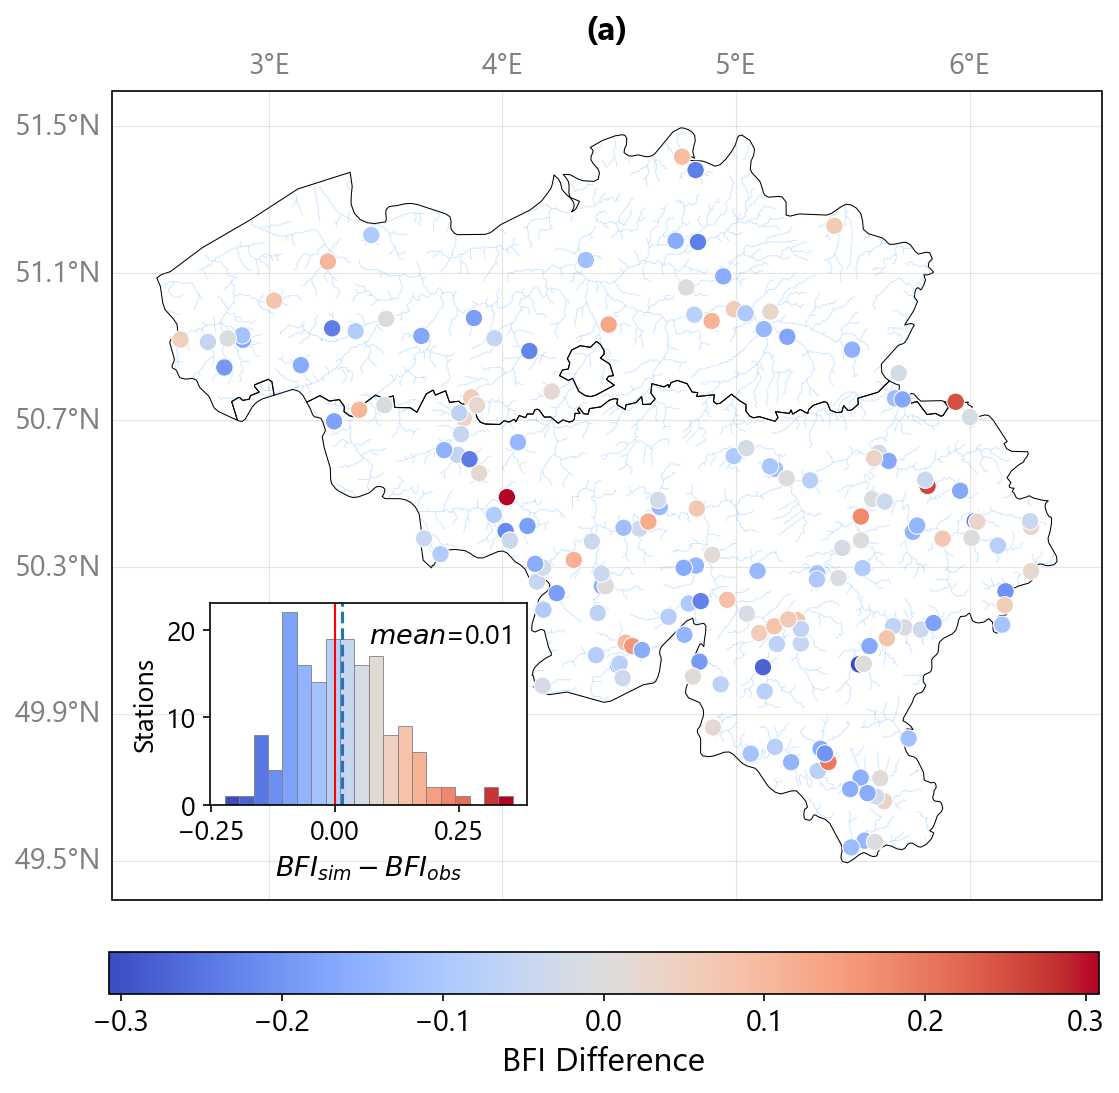

In [14]:
obs_BFI_df=eval_models_BFI['GFDL-ESM4']
bfi_diff_gdf = rf.ensemble_BFI_to_geodataframe(ensemble_bfi_df, obs_BFI_df,station_locations)
m_diff, pw = rf.wilcoxon_stats(bfi_diff_gdf)

#Difference between observed and simulated BFI
map_BFI_anomalies(bfi_diff_gdf, be_shp, rivers_shp, m_diff, pw)

_____
_____

#### Projected changes

In [15]:
def extract_scenario_multistation_baseflow(base_sim_dir, models, eval_Obs, best_bfi_method_dict):
    """  
    Extract baseflow time series for each station and model using the best method based on observed data.  
    Parameters  
    ----------
    base_sim_dir : str  
        Base directory containing model subdirectories.  
    models : list of str  
        List of model names corresponding to subdirectory names.  
    eval_Obs : dict   
        Dictionary of observed discharge time series (keyed by station name).  
    best_bfi_method_dict: dict  
        Dictionary containing best baseflow extraction method per station, based on observed data.  
 
    Returns  
    -------
    dict of pd.DataFrame  
        Dictionary with model names as keys and DataFrames with baseflow time series as values.  
    """
    # Ensure station names are uppercase for consistency
    eval_Obs_upper = rf.keys_upper(eval_Obs)

    all_models_Qb = []
    all_models_BFI = {}

    for model in models:
        print(f'\nExtracting baseflow for {model}...')
        sim_dir = f"{base_sim_dir}/{model}/Qrouted/"
        stations_Qb = []
        stations_BFI = []

        for fpath in sorted(Path(sim_dir).glob("*.csv")):
            station_name = fpath.stem.upper()

            if station_name not in eval_Obs_upper:
                continue

            sim_Q = pd.read_csv(fpath, index_col=0, parse_dates=True)

            #select best method based on observed baseflow separation
            if station_name not in best_bfi_method_dict:
                continue

            bfi_method=best_bfi_method_dict[station_name]

            #extract baseflow
            msg = f"Extracting baseflow for {station_name}"
            sys.stdout.write("\r" + msg + "  " * 20)
            sys.stdout.flush()

            #use the same best method to extract the baseflow from the simulated Q
            sim_bf_dict, sim_bfi = baseflow.separation(sim_Q, return_bfi=True, return_kge=False, method=bfi_method)
            sim_Qb= sim_bf_dict[bfi_method]
            sim_bfi = sim_bfi[bfi_method]

            sim_Qb.columns = ['sim_Qb']
            sim_Qb['station'] = station_name
            sim_Qb['Q_total'] = sim_Q['Qrouted']
            
            #rearrange columns
            sim_Qb=sim_Qb[["station", 'sim_Qb', 'Q_total']]
            stations_Qb.append(sim_Qb)

            #bfi data
            sim_bfi_df=pd.DataFrame({"sim_bfi":sim_bfi.values})
            sim_bfi_df['name'] = station_name
            sim_bfi_df['model'] = model

            sim_bfi_df=sim_bfi_df[["name","sim_bfi", "model"]]
            stations_BFI.append(sim_bfi_df)

        if stations_Qb:
            model_bf_df = pd.concat(stations_Qb)
            model_bf_df['model'] = model
            all_models_Qb.append(model_bf_df)
        
        if stations_BFI:
            model_bfi_df = pd.concat(stations_BFI)
            model_bfi_df['model'] = model
            # Optionally store BFI data if needed
            all_models_BFI[model] = model_bfi_df
            
    all_models_Qb = pd.concat(all_models_Qb,axis=0)

    return all_models_Qb, all_models_BFI

In [16]:
def seasonal_baseflow_analysis(all_models_Qb, models, season_map, Q_names):
    """  
    Analyze seasonal mean baseflow for each station and model.  
    Parameters  
    ----------
    all_models_Qb : pd.DataFrame  of models and station baseflow
        DataFrame with total flow and baseflow time series for each model and station.
    models : list of str
        List of model names corresponding to keys in all_models_Qb.
    season_map : dict
        Mapping of month numbers to season labels.  
    Q_names: list  
        Name of discharge to groupby e.g. ["obs_Qb","sim_Qb"]

    Returns  
    -------
    pd.DataFrame  
        DataFrame with columns ['name', 'model', 'season', 'obs_Qb', 'sim_Qb'] containing seasonal mean baseflow.  
    """

    seasonal_baseflow = []

    # Initialize a dictionary to hold seasonal data for the station
    for model in models:
        model_df = all_models_Qb[all_models_Qb['model'] == model]

        stations_Qb = []  # <-- collect per model

        for nameStation in model_df['station'].unique():

            station_df = model_df[model_df['station'] == nameStation]
            
            station_df = station_df.copy()
            station_df["season"] = station_df.index.month.map(season_map)

            # seasonal climatology
            season_Qb = station_df.groupby("season")[Q_names].mean().reset_index()
            season_Qb["name"] = nameStation
            season_Qb["model"] = model
            stations_Qb.append(season_Qb)
        
        if stations_Qb:  # <-- use the correct list
            model_Qb_df = pd.concat(stations_Qb)
            seasonal_baseflow.append(model_Qb_df)
        
    #convert to dataframe
    seasonal_baseflow_df = pd.concat(seasonal_baseflow)
    #rearrange columns
    seasonal_baseflow_df = seasonal_baseflow_df[["name", "model", "season"] + Q_names]

    return seasonal_baseflow_df
#=================================================
#Calculate multimodel ensemble BFI mean
def ensemble_station_BFI(all_models_BFI, sim_name):
    """  
    Concatenate simulated BFI from multiple model dictionaries
    ----------
    Parameters:
    all_model_BFI: dict  
    Dictionary containing individual model station dataframes of BFI, indexed by model name
    smi_name: str
    name of simulate Q variable

    ----------
    Returns:  
    df: ensemble average dataframe of average per station BFI
    """
    # Combine all model BFIs by 'name'
    ensemble_bfi = pd.concat(
        [df.set_index('name')[sim_name] for df in all_models_BFI.values()],
        axis=1
    )

    # Compute mean across models
    ensemble_bfi_mean = ensemble_bfi.mean(axis=1, skipna=True)

    # Convert to final DataFrame
    ensemble_bfi_df = ensemble_bfi_mean.reset_index()
    ensemble_bfi_df.columns = ['name', 'ens_BFI']

    return ensemble_bfi_df

#======================================================================
def df_to_gdf(df, stations_df):
    """ Convert dataframe to geodataframe by combining with df with station coordinates"""
    #change station_locations to upper
    stations_df['name'] = stations_df['name'].str.upper()

    #only unique station names
    station_locations_df = stations_df.drop_duplicates(subset='name').set_index('name')

    #merge station_locations with df on 'name'
    ensemble_stations = pd.concat([station_locations_df, df], axis=1).dropna()

    #to geodataframe
    gdf_ = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(ensemble_stations['lon'], ensemble_stations['lat']))
    gdf_.crs = "EPSG:4326"

    return gdf_

#======================================================================
#seasonal BFI per model and station
def extract_seasonal_BFI(scenario_BF_models, models, season_map):
    """  
    Analyze seasonal mean BFI for each station and model.  
    Parameters  
    ----------
    scenario_BF_models : pd.DataFrame  of models and station baseflow
        Dataframe with model names, Q_total and sim_Qb time series for each model and station 
    models : list of str  
        List of model names corresponding to keys in scenario_BF_models.  
    season_map : dict
        Mapping of month numbers to season labels.  

    Returns  
    -------
    pd.DataFrame  
        DataFrame with columns ['name', 'model', 'season', 'BFI'] containing seasonal mean BFI.  
    """         
    models_seasonal_BFI = []
    for model in models:
        sim_Q_model = scenario_BF_models[scenario_BF_models['model'] == model].copy()
        #map seasons
        sim_Q_model['season'] = sim_Q_model.index.month.map(season_map)

        # Seasonal sums per station
        aggregated_flow = sim_Q_model.groupby(['station','season'])[['sim_Qb','Q_total']].sum().reset_index()

        # Calculate BFI, handling division by zero
        aggregated_flow['BFI'] = np.divide(aggregated_flow['sim_Qb'].to_numpy(),
                                    aggregated_flow['Q_total'].to_numpy(),
                                    out=np.zeros(len(aggregated_flow), dtype=float),
                                    where=aggregated_flow['Q_total'].to_numpy() != 0)

        model_seasonal_BFI = (aggregated_flow
        .pivot(index='station', columns='season', values='BFI')
        .reindex(columns=['DJF','MAM','JJA','SON'])
        .rename_axis(None, axis=1)
        .reset_index()
        .rename(columns={'station':'name'})
        )
        model_seasonal_BFI['model'] = model
        models_seasonal_BFI.append(model_seasonal_BFI)

    model_seasonal_BFI = pd.concat(models_seasonal_BFI)

    return model_seasonal_BFI

def seasonalize_baseflow(all_models_Qb, season_map=None, Q_names=("sim_Qb")):

    Q_names = list(Q_names)
    df = all_models_Qb.copy()

    df['season'] = df.index.month.map(season_map)

    bf_season_mean = (pd.pivot_table(df, values=Q_names,
                           index=['model','station'],
                           columns='season',
                           aggfunc='mean', observed=True)
              .reindex() 
            )
    bf_season_mean = bf_season_mean.reset_index().rename(columns={'station': 'name'})
    season_list = bf_season_mean.columns.get_level_values(1).to_list()
    bf_season_mean.columns = ['model', 'name'] + season_list[2:]
    return bf_season_mean


#======================================================================


##### Extract seasonal flow for all scenarios
Extract baseflow for hist and future SSP scenarios

In [17]:
Q_names=['sim_Qb']

baseflow_scenarios = {}
bfi_scenarios={}
seasonal_BFI={}
#changes in baseflow under respective scenarios
for scenario in scenarios:
    base_sim_dir = f"{os.path.join(base_dir, 'isimip_Q', scenario)}"

    #Extract and seasonalize total discharge
    print(f"\nextracting baseflow for {scenario}")
    scenario_BF_models, all_models_BFI = extract_scenario_multistation_baseflow(base_sim_dir, models, eval_Obs, best_method)
    
    #seasonal BF totals
    print(f"\nseasonal BFI for {scenario}")
    seasonal_bf=seasonalize_baseflow(scenario_BF_models, season_map, Q_names)
    baseflow_scenarios[scenario] = seasonal_bf

    #seasonal BFI per model and station
    print(f"\n Extracting seasonal BFI for {scenario}")
    seasonal_bfi_per_model = extract_seasonal_BFI(scenario_BF_models, models, season_map)

    seasonal_BFI[scenario]=seasonal_bfi_per_model
    
    #compute ensemble BFI for the scenario
    ensemble_scenario_bfi = pd.concat(
        [df.set_index('name') for df in all_models_BFI.values()],
        axis=0
    )
    ensemble_scenario_bfi['scenario'] = scenario
    bfi_scenarios[scenario] = ensemble_scenario_bfi


extracting baseflow for historical

Extracting baseflow for GFDL-ESM4...
Extracting baseflow for ZICHEM_DEMER                                                         
Extracting baseflow for IPSL-CM6A-LR...
Extracting baseflow for ZICHEM_DEMER                                                         
Extracting baseflow for MPI-ESM1-2-HR...
Extracting baseflow for ZICHEM_DEMER                                                         
Extracting baseflow for MRI-ESM2-0...
Extracting baseflow for ZICHEM_DEMER                                                         
Extracting baseflow for UKESM1-0-LL...
Extracting baseflow for ZICHEM_DEMER                                                         
seasonal BFI for historical

 Extracting seasonal BFI for historical

extracting baseflow for ssp370

Extracting baseflow for GFDL-ESM4...
Extracting baseflow for ZICHEM_DEMER                                                         
Extracting baseflow for IPSL-CM6A-LR...
Extracting baseflow for Z

##### Compute Projected changes under CC

Projected changes in annual Baseflow

In [18]:
#annual projected baseflow changes
bf_delta_gdf={}

future_scenarios = ['ssp370', 'ssp585']
hist_bf_df=baseflow_scenarios['historical'].groupby('name').mean(numeric_only=True)
for scenario in future_scenarios:
    scenario_df=baseflow_scenarios[scenario].groupby('name').mean(numeric_only=True)
    bf_change_df= 100 * (scenario_df - hist_bf_df)/hist_bf_df
    
    #convert to gdf for mapping
    bf_change_gdf = df_to_gdf(bf_change_df, station_locations)
    bf_delta_gdf[scenario] = bf_change_gdf

##### Seasonal Baseflow

In [19]:
#Seasonal projected baseflow changes
bf_seasonal_delta_gdf={}

hist_seasonal_bf_df=baseflow_scenarios['historical'].groupby(['name']).mean(numeric_only=True)
for scenario in future_scenarios:
    bf_per_season = []
    scenario_df = baseflow_scenarios[scenario].groupby(['name']).mean(numeric_only=True)
    seasonal_delta = 100 * (scenario_df - hist_seasonal_bf_df) / hist_seasonal_bf_df
    df = seasonal_delta
    #convert to gdf for mapping
    seasonal_change_gdf = df_to_gdf(df, station_locations)

    #append to dictionary
    bf_seasonal_delta_gdf[scenario] = seasonal_change_gdf

In [21]:
def map_baseflow_stats_seasonal(
    seasonal_delta_dict,      # dict[str, GeoDataFrame] with columns: ['name','DJF','MAM','JJA','SON','geometry']
    boundaries_shp,           # GeoDataFrame boundaries
    streams_shp,              # GeoDataFrame rivers
    scenarios=('ssp370', 'ssp585'),
    seasons=('DJF', 'MAM', 'JJA', 'SON'),
    c_map='RdBu_r',           # diverging colormap suits +/- changes
    point_size=50,            # constant marker size
    figsize=(12, 8),
    dpi=150,
    gridlines=True,
    show_hist=True
):
    """
    2x4 seasonal maps. Row 0 = first scenario, Row 1 = second scenario.
    Expects each GDF in seasonal_delta_dict to have one column per season.
    Returns: fig, axes (2D array), cbar
    """
    # ---- gather global value range across scenarios & seasons ----
    all_vals = []
    for scen in scenarios:
        gdf = seasonal_delta_dict[scen]
        for seas in seasons:
            if seas in gdf.columns:
                all_vals.append(gdf[seas].to_numpy(dtype=float))
    all_vals = np.concatenate(all_vals) if all_vals else np.array([0.0])

    # keep 0 strictly inside the range for TwoSlopeNorm
    finite = all_vals[np.isfinite(all_vals)]
    vmin_g = float(np.nanmin(finite)) if finite.size else -1.0
    vmax_g = float(np.nanmax(finite)) if finite.size else  1.0
    eps = max(1e-9, (vmax_g - vmin_g) * 1e-6)

    # Use TwoSlopeNorm centered at 0 if values straddle 0; otherwise fall back to Normalize
    if vmin_g < 0 < vmax_g:
        vmin, vmax = vmin_g, vmax_g
    elif vmin_g >= 0:  # all data ≥ 0 -> keep a tiny negative headroom
        vmin, vmax = 0 - eps, vmax_g
    else:
        vmin, vmax = vmin_g, vmax_g
  
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(c_map)
    sm = ScalarMappable(norm=norm, cmap=cmap)

    # ---- layout ----
    nrows, ncols = 2, 4
    fig, axs = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi,
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # column titles = seasons
    for j, seas in enumerate(seasons):
        axs[0, j].set_title(seas, fontsize=12, weight='bold')

    # row labels = scenarios
    axs[0,0].text(-0.18, 0.5, scenarios[0].upper(), va='center', ha='right',
                  rotation=90, transform=axs[0,0].transAxes, fontsize=12, weight='bold')
    axs[1,0].text(-0.18, 0.5, scenarios[1].upper(), va='center', ha='right',
                  rotation=90, transform=axs[1,0].transAxes, fontsize=12, weight='bold')

    # ---- draw panels ----
    for i, scen in enumerate(scenarios):
        gdf_all = seasonal_delta_dict[scen]
        xs = gdf_all.geometry.x
        ys = gdf_all.geometry.y

        for j, seas in enumerate(seasons):
            ax = axs[i, j]
            vals = gdf_all[seas].to_numpy(dtype=float)

            # background layers
            boundaries_shp.plot(ax=ax, linewidth=0.5, edgecolor='black', facecolor='none',
                                zorder=1)
            streams_shp.plot(ax=ax, linewidth=0.5, alpha=0.2, edgecolor='dodgerblue',
                             facecolor='none', zorder=2)

            # points (color encodes seasonal value)
            ax.scatter(
                xs, ys,
                c=vals, s=point_size,
                cmap=cmap, norm=norm,
                edgecolor='white', linewidth=0.5,
                transform=ccrs.PlateCarree(), zorder=3
            )
            #frame
            # Turn frame on (draw spines)
            ax.set_frame_on(True)

            # Loop over all spines (top, bottom, left, right) and set color/width
            for spine in ax.spines.values():
                spine.set_edgecolor('gray')
                spine.set_linewidth(0.5)


            if gridlines:
                gl = ax.gridlines(draw_labels=True, color='gray', lw=0.6, alpha=0.2)
                gl.top_labels = False
                gl.right_labels = False
                gl.left_labels = (j == 0)         # only left column
                gl.bottom_labels = (i == nrows-1) # only bottom row
                #gridline spacing
                gl.ylocator = mpl.ticker.FixedLocator(np.arange(49, 52.1, 0.5))

            if show_hist:
                ax_hist = inset_axes(ax, width="25%", height="20%",
                                     bbox_to_anchor=(-.57, -.58, 1.0, 1.0),
                                     bbox_transform=ax.transAxes)
                data = vals[np.isfinite(vals)]
                counts, bins, patches = ax_hist.hist(data, bins=10)
                centers = 0.5 * (bins[:-1] + bins[1:])
                for cval, patch in zip(centers, patches):
                    patch.set_facecolor(sm.to_rgba(cval))
                    patch.set_edgecolor('gray')
                    patch.set_linewidth(0.4)
                m = np.nanmean(data) if data.size else np.nan
                ax_hist.axvline(m, linewidth=0.9,c='k')
                ax_hist.text(0.35, 1.50, f"{np.round(m,1)}%", transform=ax_hist.transAxes,
                             ha='right', va='top', fontsize=10, weight='bold', color='green')
                ax_hist.set_xlim(norm.vmin, norm.vmax)
                ax_hist.set_xlabel("ΔBF (%)", fontsize=9)
                ax_hist.set_ylabel("Stations", fontsize=7)
                ax_hist.tick_params(axis='both', labelsize=8)
                ax_hist.grid(alpha=0.3)

    # ---- shared colorbar ----
    cax = fig.add_axes([1.0, 0.095, 0.02, 0.80]) #left, bottom, width, height
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    cbar.set_label('Projected change in BF (%)', fontsize=14)
    cbar.ax.tick_params(labelsize=10)

    fig.tight_layout()
    return fig, axs, cbar

C:\Users\kart\AppData\Local\Temp\ipykernel_18840\2011600581.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


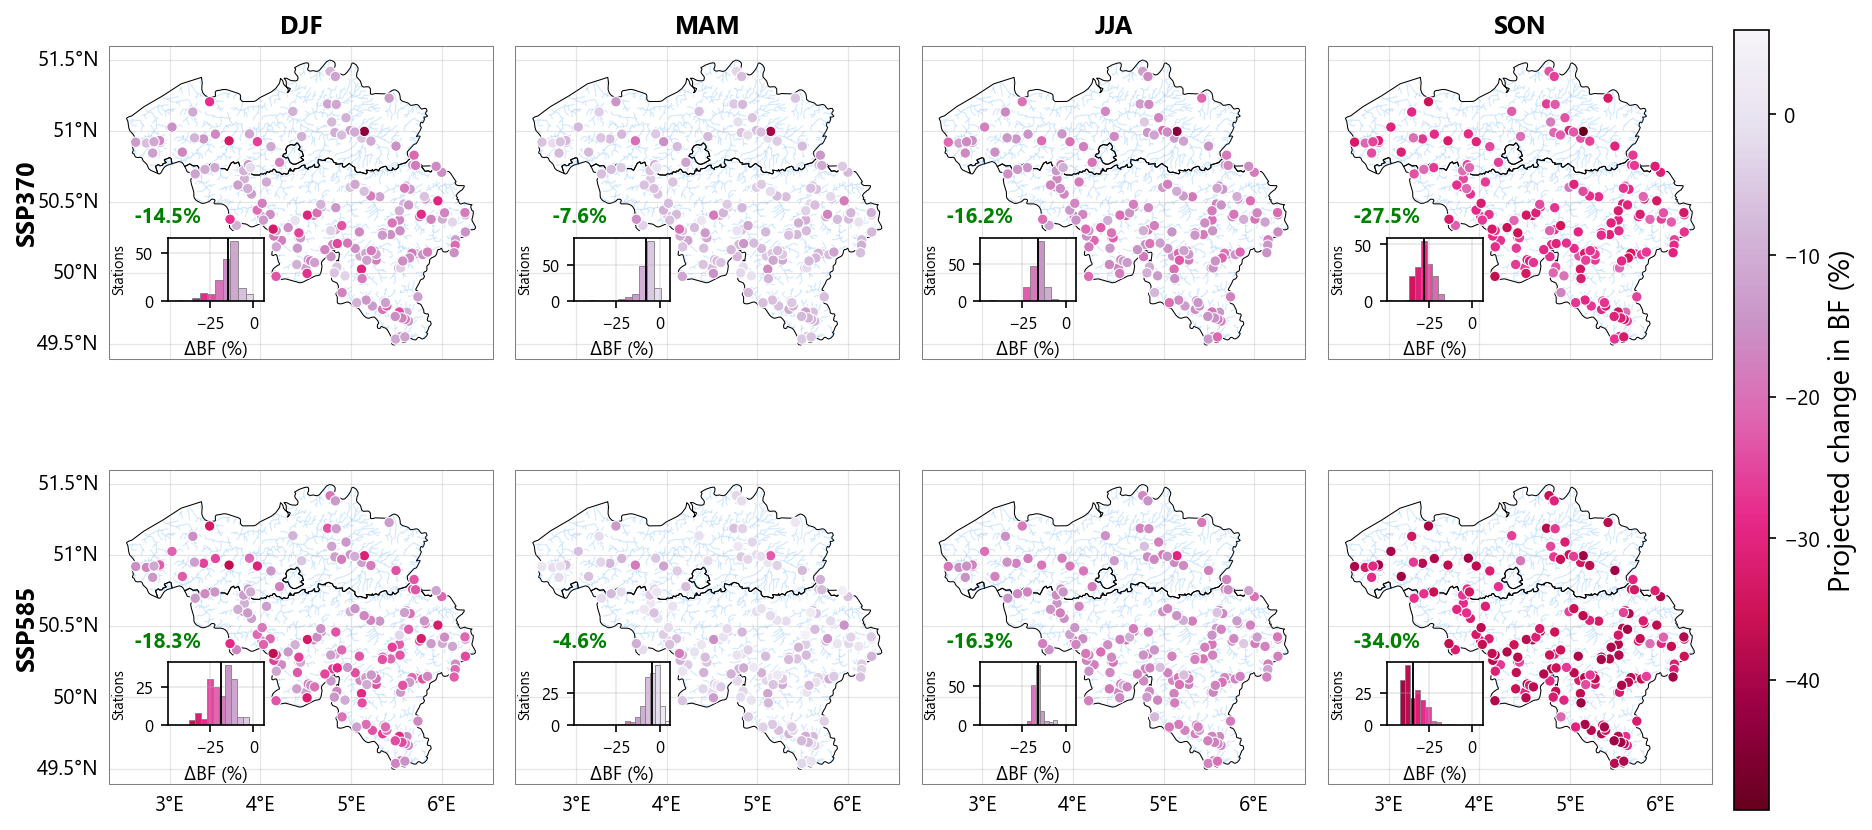

In [22]:

fig, axs, cbar = map_baseflow_stats_seasonal(
    bf_seasonal_delta_gdf,      # dict[str, GeoDataFrame] with columns: ['name','DJF','MAM','JJA','SON','geometry']
    be_shp,           # GeoDataFrame boundaries
    rivers_shp,              # GeoDataFrame rivers
    scenarios=('ssp370', 'ssp585'),
    seasons=('DJF', 'MAM', 'JJA', 'SON'),
    c_map='PuRd_r',           # diverging colormap suits +/- changes
    point_size=25,            # constant marker size
    figsize=(11.5, 6.5),
    dpi=150,
    gridlines=True,
    show_hist=True
)
plt.show()

In [23]:

def map_baseflow_stats_seasonal(
    seasonal_delta_dict,      # {'ssp370': gdf, 'ssp585': gdf} with ['name','DJF','MAM','JJA','SON','geometry']
    boundaries_shp,
    streams_shp,
    scenarios=('ssp370', 'ssp585'),
    seasons=('DJF', 'MAM', 'JJA', 'SON'),
    c_map='RdBu_r',
    point_size=50,
    figsize=(12, 8),
    dpi=150,
    gridlines=True,
    show_hist=True
):
# ---- gather global value range across scenarios & seasons ----
    all_vals = []
    for scen in scenarios:
        gdf = seasonal_delta_dict[scen]
        for seas in seasons:
            if seas in gdf.columns:
                all_vals.append(gdf[seas].to_numpy(dtype=float))
    all_vals = np.concatenate(all_vals) if all_vals else np.array([0.0])

    # keep 0 strictly inside the range for TwoSlopeNorm
    finite = all_vals[np.isfinite(all_vals)]
    vmin_g = float(np.nanmin(finite)) if finite.size else -1.0
    vmax_g = float(np.nanmax(finite)) if finite.size else  1.0
    eps = max(1e-9, (vmax_g - vmin_g) * 1e-6)

    # Use TwoSlopeNorm centered at 0 if values straddle 0; otherwise fall back to Normalize
    if vmin_g < 0 < vmax_g:
        vmin, vmax = vmin_g, vmax_g
    elif vmin_g >= 0:  # all data ≥ 0 -> keep a tiny negative headroom
        vmin, vmax = 0 - eps, vmax_g
    else:
        vmin, vmax = vmin_g, vmax_g
  
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(c_map)
    sm = ScalarMappable(norm=norm, cmap=cmap)
    # ---- layout: seasons as rows, scenarios as cols ----
    nrows, ncols = len(seasons), len(scenarios)
    fig, axs = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi,
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    axs = np.atleast_2d(axs)

    # column titles = scenarios
    for j, scen in enumerate(scenarios):
        axs[0, j].set_title(scen.upper(), fontsize=12, weight='bold')

    # row labels = seasons
    for i, seas in enumerate(seasons):
        axs[i, 0].text(-0.16, 0.5, seas, va='center', ha='right',
                       rotation=90, transform=axs[i, 0].transAxes,
                       fontsize=12, weight='bold')

    # ---- draw panels ----
    for i, seas in enumerate(seasons):          # rows
        for j, scen in enumerate(scenarios):    # cols
            ax = axs[i, j]
            gdf = seasonal_delta_dict[scen]
            if seas not in gdf.columns:
                ax.set_axis_off(); continue

            xs = gdf.geometry.x
            ys = gdf.geometry.y
            vals = gdf[seas].to_numpy(dtype=float)

            boundaries_shp.plot(ax=ax, linewidth=0.5, edgecolor='black', facecolor='none', zorder=1)
            streams_shp.plot(ax=ax, linewidth=0.5, alpha=0.2, edgecolor='dodgerblue', facecolor='none', zorder=2)

            ax.scatter(xs, ys, c=vals, s=point_size, cmap=cmap, norm=norm,
                       edgecolor='white', linewidth=0.5,
                       transform=ccrs.PlateCarree(), zorder=3)

            if gridlines:
                gl = ax.gridlines(draw_labels=True, color='gray', lw=0.6, alpha=0.2)
                gl.top_labels = False
                gl.right_labels = False
                gl.left_labels = (j == 0)            # only first column
                gl.bottom_labels = (i == nrows - 1)   # only last row
                gl.ylocator = mpl.ticker.FixedLocator(np.arange(49, 52.1, 0.5))
                #labelsize
                gl.xlabel_style = {'size': 8}
                gl.ylabel_style = {'size': 8}

                #frame
            # Turn frame on (draw spines)
            ax.set_frame_on(True)

            # Loop over all spines (top, bottom, left, right) and set color/width
            for spine in ax.spines.values():
                spine.set_edgecolor('gray')
                spine.set_linewidth(0.5)

            if show_hist:
                ax_hist = inset_axes(ax, width="27%", height="20%",
                                     bbox_to_anchor=(-.57, -.60, 1.0, 1.0),
                                     bbox_transform=ax.transAxes)
                data = vals[np.isfinite(vals)]
                counts, bins, patches = ax_hist.hist(data, bins=10)
                centers = 0.5 * (bins[:-1] + bins[1:])
                for cval, patch in zip(centers, patches):
                    patch.set_facecolor(sm.to_rgba(cval))
                    patch.set_edgecolor('gray')
                    patch.set_linewidth(0.4)
                if data.size:
                    m = float(np.nanmean(data))
                    ax_hist.axvline(m, linewidth=0.7,c='k')
                    ax_hist.text(0.35, 1.25, f"{m:.1f}%", transform=ax_hist.transAxes,
                                 ha='right', va='top', fontsize=10, c='dodgerblue', weight='bold')
                ax_hist.set_xlim(norm.vmin, norm.vmax)
                #change figure thickness
                for spine in ax_hist.spines.values():
                    spine.set_edgecolor('gray')
                    spine.set_linewidth(0.5)
                ax_hist.grid(alpha=0.3)
                ax_hist.set_xlabel("BF change (%)", fontsize=8)
                ax_hist.set_ylabel("Stations", fontsize=8)
                ax_hist.tick_params(axis='both', labelsize=6)

    # ---- shared colorbar ----
    cax = fig.add_axes([0.88, 0.08, 0.03, 0.87]) #left, bottom, width, height
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    cbar.set_label('Projected change in BF (%)', fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    fig.tight_layout(rect=[0.03, 0.05, 0.90, 0.98])
    return fig, axs, cbar


C:\Users\kart\AppData\Local\Temp\ipykernel_18840\2918212260.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.03, 0.05, 0.90, 0.98])


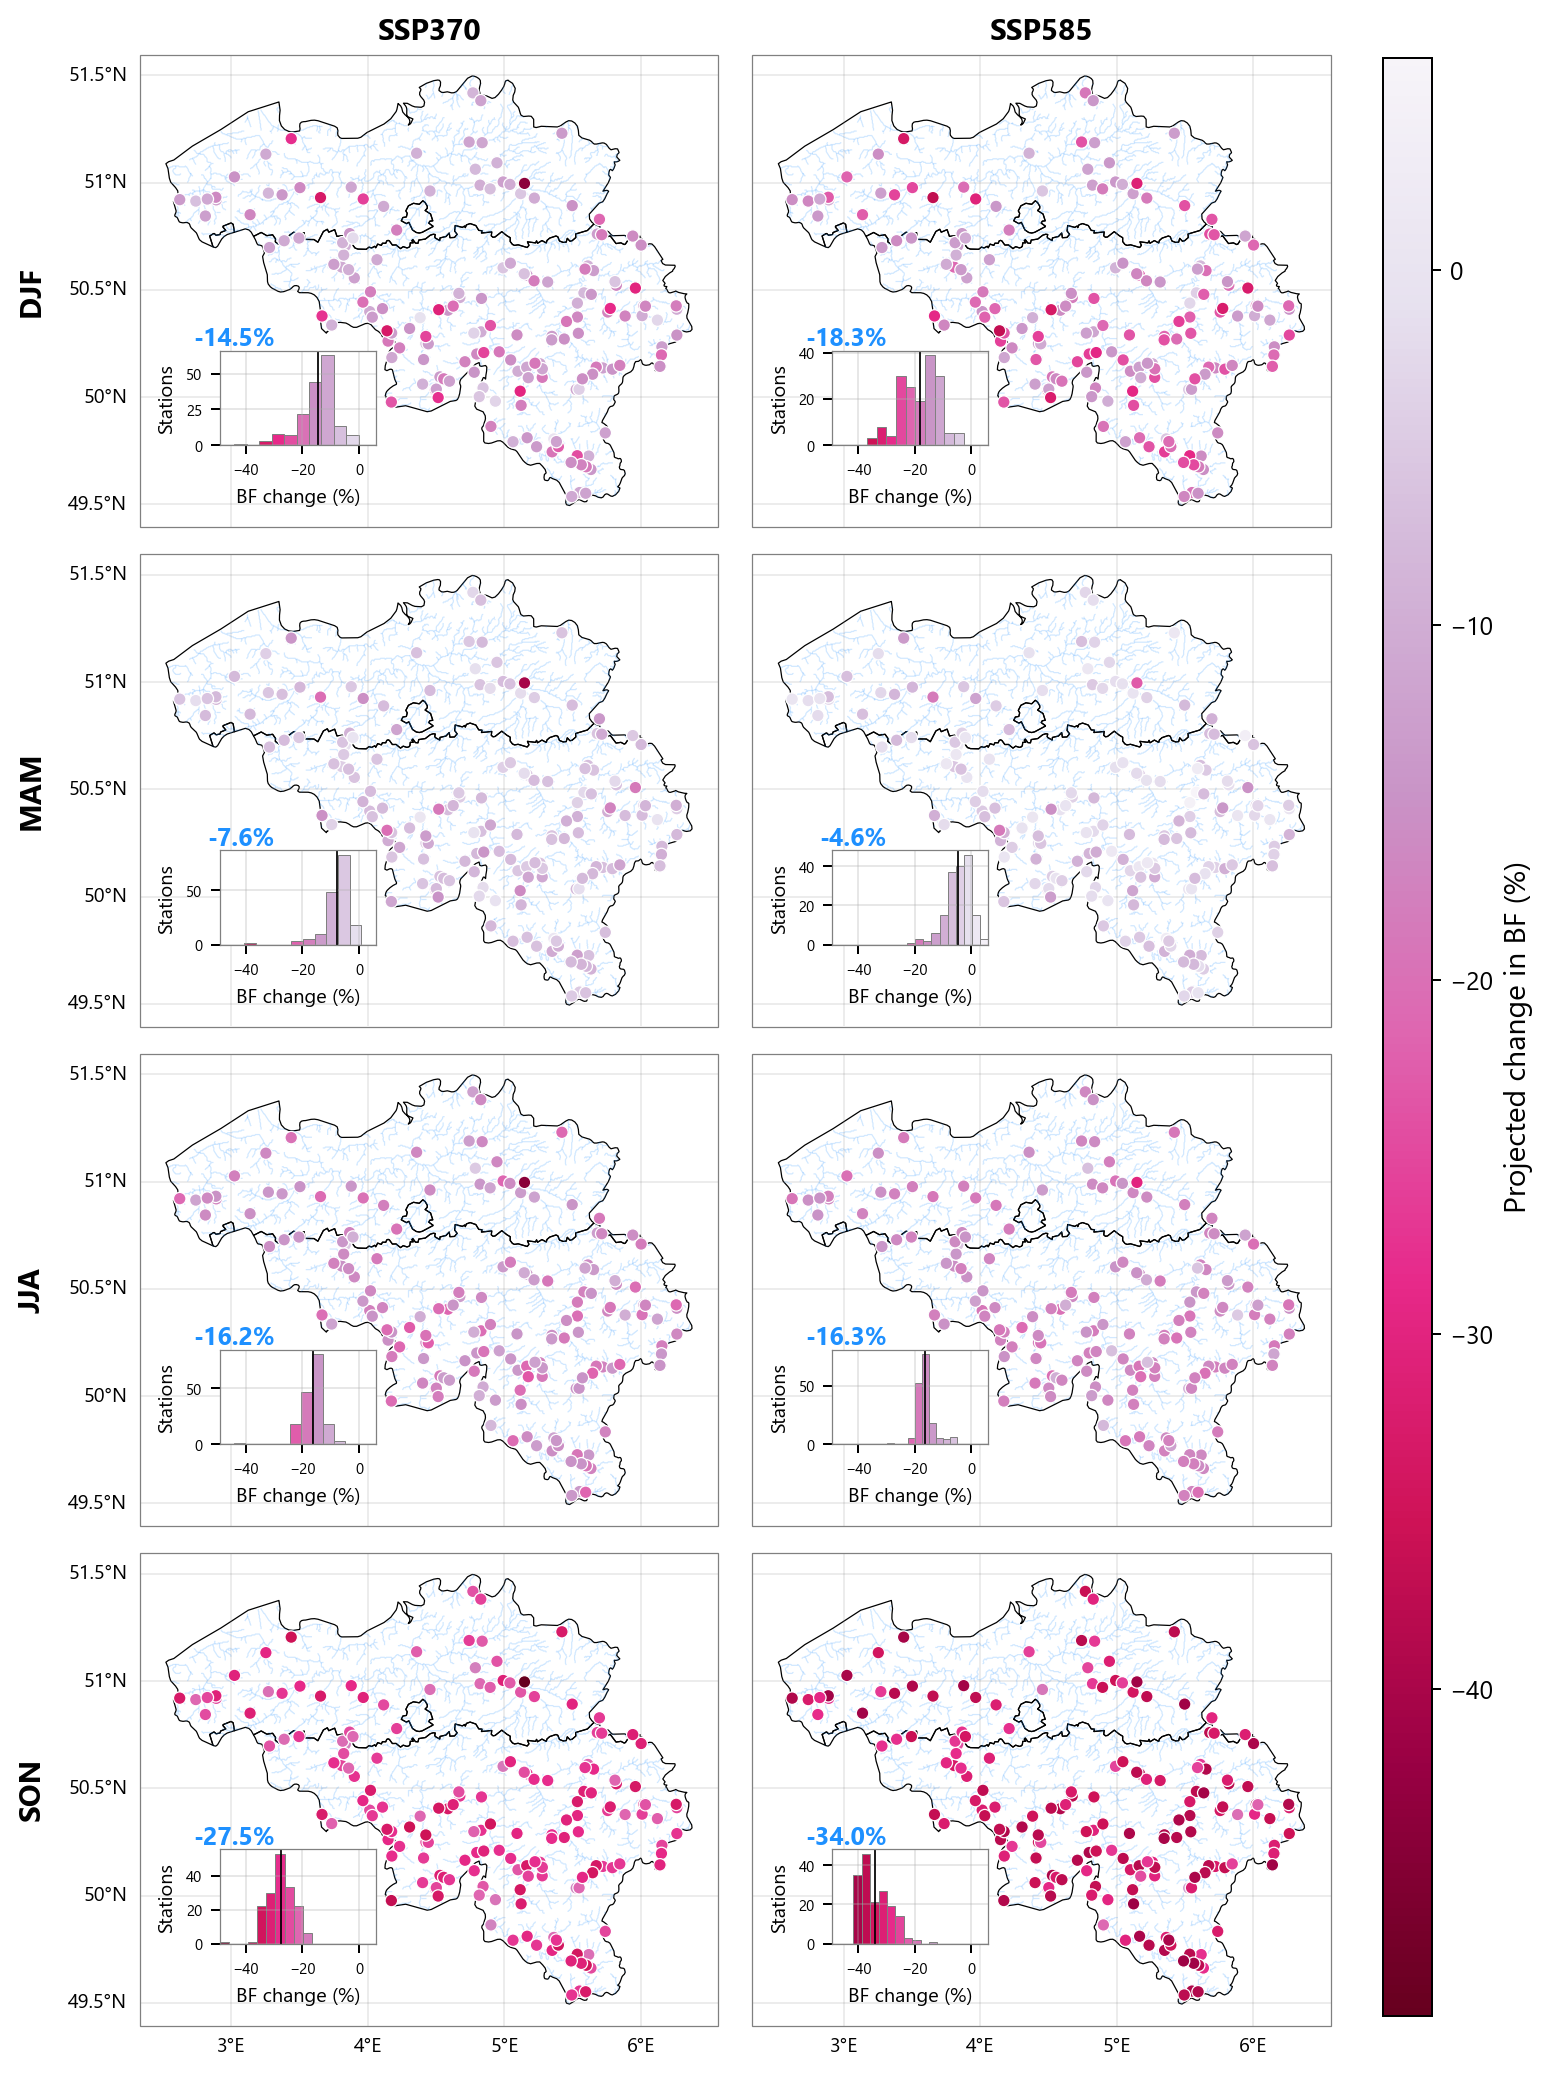

In [24]:

fig, axs, cbar = map_baseflow_stats_seasonal(
    bf_seasonal_delta_gdf,      # dict[str, GeoDataFrame] with columns: ['name','DJF','MAM','JJA','SON','geometry']
    be_shp,           # GeoDataFrame boundaries
    rivers_shp,              # GeoDataFrame rivers
    scenarios=('ssp370', 'ssp585'),
    seasons=('DJF', 'MAM', 'JJA', 'SON'),
    c_map='PuRd_r',           # diverging colormap suits +/- changes
    point_size=25,            # constant marker size
    figsize=(9.0, 12.5),
    dpi=180,
    gridlines=True,
    show_hist=True
)
plt.show()

#### Recharge assessment

In [216]:
def seasonal_clim(ds, var, be_shp):
    """Calculate seasonal climatology for a given variable and region.
    Parameters
    ----------
    ds : xarray.Dataset
        Input dataset containing the variable of interest.
    var : str
        Name of the variable to process.
    be_shp : GeoDataFrame
        Geographical region to clip the dataset to.
    Returns
    -------
    xarray.Dataset
        Seasonal climatology of the specified variable.

    """
    ds = rf.clip_to_region(be_shp, ds)
    # totals per season-year
    seas = ds[[var]].resample(time="QS-DEC").sum()
    # climatology over seasons
    return seas.groupby("time.season").mean("time")
#=================================================
def compute_delta_recharge(models, base_dir,nc_file, var, be_shp, future_scenarios, min_season_mm):
    """Compute seasonal recharge changes for multiple models and scenarios.
    Parameters
    ----------
    models : list of str
        List of model names.
    base_dir : str
        Directory containing model output files.
    nc_file : str
        Name of the NetCDF file containing groundwater fluxes.
    var : str
        Name of the recharge variable in the dataset.
    be_shp : GeoDataFrame
        Geographical region to clip the datasets to.
    future_scenarios : list of str
        List of future scenarios to analyze.
    min_season_mm : float
        Minimum seasonal recharge threshold for masking.

    Returns
    -------
    dict
        Dictionary containing DataArrays for percentage change, annual equivalent effect, and absolute change for each model and scenario.
    """
    model_Gr_Fluxes = {}
    for model in models:
        # historical seasonal climatology & annual baseline
        hist = xr.open_dataset(f"{base_dir}/{model}/historical/{nc_file}")
        hist_seasonal = seasonal_clim(hist, var, be_shp)
        if var == "recharge":
            min_season_mm = 5.0      # mask seasonal % and AEE where hist season < 5 mm

        hist_annual = hist_seasonal.sum("season")  # annual baseline per pixel (mm/yr)

        for scenario in future_scenarios:
            fut = xr.open_dataset(f"{base_dir}/{model}/{scenario}/{nc_file}")
            fut_seasonal = seasonal_clim(fut, var, be_shp)

            delta = fut_seasonal - hist_seasonal  # mm/season
            # safe denominators
            hist_mask = hist_seasonal.where(hist_seasonal >= min_season_mm)
            annual_mask = hist_annual.where(hist_annual >= 4 * min_season_mm)

            pct = 100.0 * (delta / hist_mask)             # % change per season
            
            #annual equivalent effect (AEE) = seasonal change scaled to annual baseline
            #answers the question: how much does this season move the yearly water budget?
            aee = 100.0 * (delta / annual_mask)           # % of annual baseline

            # keep sign, drop explosions
            pct = pct.where(np.isfinite(pct))
            aee = aee.where(np.isfinite(aee))

            model_Gr_Fluxes[f"{model}_{scenario}_pct"] = pct
            model_Gr_Fluxes[f"{model}_{scenario}_AE"]  = aee
            model_Gr_Fluxes[f"{model}_{scenario}_abs"] = delta  # handy for plots
    
    return model_Gr_Fluxes

#====================================================================================

#stack models on keys
def stack_models(model_Gr_Fluxes, model_keys):
    stacked_models_Gr_Fluxes = []
    for key in model_keys:
        model_da = model_Gr_Fluxes[key].assign_coords(model=key.split("_")[0])
        model_da = model_da.expand_dims("model")
        stacked_models_Gr_Fluxes.append(model_da)

    da = xr.concat(stacked_models_Gr_Fluxes, dim="model")
    return da
#==================================================================================

def ensemble_robustness(model_fluxes, models, change_var, scenarios):
    """Assess the robustness of model projections under different scenarios.
    Parameters
    ----------
    model_fluxes : dict
        Dictionary containing model flux DataArrays, keyed by strings of the form
        "{model}_{scenario}_{change_var}".
    models : list of str
        List of model names.
    change_var : str
        Variable indicating the type of change (e.g., 'pct', for percentage change, 'AE' for annual equivalent effect, 'abs' for absolute change).
    scenarios : list of str
        List of scenario names.
    Returns
    -------
    dict
        Dictionary containing robustness metrics for each scenario. Each entry contains:
        - 'ens_mean': Ensemble mean change.
        - 'ens_median': Ensemble median change.
        - 'ens_std': Standard deviation across models.
        - 'ci95': 95% confidence interval of the mean.
        - 'agree_on_sign': Fraction of models agreeing on the sign of the mean change.
        - 'robust': Robustness mask (1=increase, -1=decrease, 0=not robust).
        - 'snr': Signal-to-noise ratio across models
    
    """
    recharge_results = {}
    #Multi-model uncertainty analysis
    for scenario in scenarios:
        keys = [f"{m}_{scenario}_{change_var}" for m in models]
        if change_var not in ['pct', 'AE', 'abs']:
            raise ValueError("change_var must be one of 'pct', 'AE', or 'abs'")
        ens = stack_models(model_fluxes, keys)                                  # dims: model, season, lat, lon

        ens_mean   = ens.mean('model')                             # ensemble mean % change
        ens_median = ens.median('model')                           # ensemble median % change
        ens_std    = ens.std('model')                              # spread across models
        n          = ens.sizes['model']
        ci95       = 1.96 * ens_std / np.sqrt(n)                   # 95% CI of the mean

        # Fraction of models agreeing on the sign of the multi-model mean (IPCC-style)
        pos_frac = (ens > 0).mean('model')
        neg_frac = (ens < 0).mean('model')
        agree_on_sign = xr.where(ens_mean > 0, pos_frac, neg_frac) # 0..1

        # Robustness mask:
        # "robust increase" if ens_mean>0 and ≥80% models agree;
        # "robust decrease" if ens_mean<0 and ≥80% agree; else "no robust signal".
        robust_increase = (ens_mean > 0) & (pos_frac >= 0.8)
        robust_decrease = (ens_mean < 0) & (neg_frac >= 0.8)
        robust = xr.where(robust_increase, 1, xr.where(robust_decrease, -1, 0))
        # robust: 1=increase, -1=decrease, 0=not robust

        # Optional: signal-to-noise ratio across models
        snr = xr.where(ens_std > 0, np.abs(ens_mean) / ens_std, np.nan)

        recharge_results[scenario] = {
            'ens_mean': ens_mean,
            'ens_median': ens_median,
            'ens_std': ens_std,
            'ci95': ci95,
            'agree_on_sign': agree_on_sign,
            'robust': robust,
            'snr': snr,
        }
    return recharge_results

#======================================================
def plot_ensemble_recharge_stats(ensemble_stats, scenarios, seasons, ensemble_stat, variable, shp, cmap, snr_thresh=0.8):
    """
    Plot ensemble statistics for seasonal precipitation changes for multiple scenarios.
    Parameters
    ----------
    ensemble_stats : dict
        Dictionary with ensemble statistics for each scenario.
    seasons : list
        List of seasons to plot (e.g., ['DJF', 'MAM', 'JJA', 'SON']).
    scenarios : list
        List of scenarios to plot (e.g., ['ssp370', 'ssp585']).
    ensemble_stat : str
        Ensemble statistic to plot (e.g., 'ens_mean', 'ens_median', 'snr_model').
    variable : str
        Model variable being analyzed (e.g., 'recharge', 'Q', etc.).
    cmap : str
        Colormap for plotting.
    snr_thresh : float, optional
        Threshold for signal-to-noise ratio masking (default is 0.8).
    shp : geopandas.GeoDataFrame
        Shapefile for plotting boundaries.
    Returns
    -------
    Plot of ensemble statistics with shared color scale and colorbar.
    """

    # extract scenario statistic for each scenario
    da_ens_list = []
    for scenario in scenarios:
        da= ensemble_stats[scenario][ensemble_stat][variable]
        da_ens_list.append(da)

    # shared vmin/vmax across BOTH SSPs and ALL seasons
    stack = xr.concat(da_ens_list, dim='stack_for_scale')
    vmin = np.nanpercentile(stack, 2.5)
    vmax = np.nanpercentile(stack, 97.5)
    if vmax < abs(vmin):
        vmax = abs(vmin)
        if vmin > -abs(vmax):
            vmin = -abs(vmax)
    # shapefile to lon/lat
    be = shp.to_crs(epsg=4326)

    fig, axes = plt.subplots(
        nrows=len(scenarios), ncols=len(seasons),
        figsize=(14, 6.5),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    for r, da in enumerate(da_ens_list):
        for c, s in enumerate(seasons):
            ax = axes[r, c]
            be.boundary.plot(ax=ax, linewidth=0.2, color='black')  # no transform
            if ensemble_stat in ['snr'] and snr_thresh is not None:
                im = da.sel(season=s).where(da.sel(season=s) >= snr_thresh).plot(
                    ax=ax, cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax,
                     transform=ccrs.PlateCarree()
                )
            else:
                im = da.sel(season=s).plot(
                    ax=ax, cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax,
                    transform=ccrs.PlateCarree()
                )

            ax.set_title('')  # no title here, we add it later

            #gridlines
            gl = ax.gridlines(draw_labels=True, color='gray', lw=0.6, alpha=0.2)
            gl.bottom_labels = (r == len(scenarios)-1)
            gl.top_labels   = False
            gl.left_labels  = (c==0)
            gl.right_labels = False
            gl.xlocator = mticker.FixedLocator(np.arange(0, 10, 1))
            gl.ylocator = mticker.FixedLocator(np.arange(49.5, 51.9, 0.5))
            gl.xlabel_style = {'size': 10, 'color': 'gray'}
            gl.ylabel_style = {'size': 10, 'color': 'gray'}

            # Loop over all spines (top, bottom, left, right) and set color/width
            for spine in ax.spines.values():
                spine.set_edgecolor('gray')
                spine.set_linewidth(0.6)

    # column titles = seasons
    for c, s in enumerate(seasons):
        axes[0, c].set_title(s, fontsize=12, pad=6, color='k')

    # row labels = SSPs
    for r, ssp_label in enumerate(scenarios):
        axes[r, 0].text(-0.20, 0.5, str.upper(ssp_label), rotation=90, va='center', ha='right',
                        transform=axes[r, 0].transAxes, fontsize=12, color='k', weight='bold')

    # shared colorbar
    fig.subplots_adjust(right=0.88, wspace=0.02, hspace=0.06)
    cax = fig.add_axes([0.9, 0.11, 0.02, 0.77])  # left, bottom, width, height
    cb = fig.colorbar(im, cax=cax, orientation='vertical', extend='both')
    cb.ax.set_ylabel('Mean Seasonal Precipitation Change (%)', fontsize=12)
    cb.ax.tick_params(labelsize=12)

    #dont call plt.show() here, do it when executing the function
    return fig, axes, cb

In [205]:
DIR = r"D:\VUB\_data\_isimip_3b\model_outputs\mHM_Gr_Fluxes"
var = "recharge"

model_Gr_Fluxes = compute_delta_recharge(
    models,
    base_dir=DIR,
    nc_file="mHM_Gr_Fluxes.nc",
    var=var,
    be_shp=be_shp,
    future_scenarios=future_scenarios,
    min_season_mm=5.0
)

#### Uncertainty assessment

In [210]:
#create a mask to filter out edge pixels in the NW
ensemble_metrics = ensemble_robustness(model_Gr_Fluxes, models, change_var='pct', scenarios=future_scenarios)

ds = ensemble_metrics['ssp585']['robust']['recharge'].sel(season='SON')
mask = ds.where(ds < 0)

#Mask the data
domain_recharge_stats = {}
for scen in future_scenarios:
    scenario_stats = {}
    for ens_stat in ensemble_metrics[scen].keys():
        da = ensemble_metrics[scen][ens_stat]
        da_masked = da.where(mask.notnull())
        scenario_stats[ens_stat] = da_masked
    domain_recharge_stats[scen] = scenario_stats

#### Plot Recharge changes and uncertainty

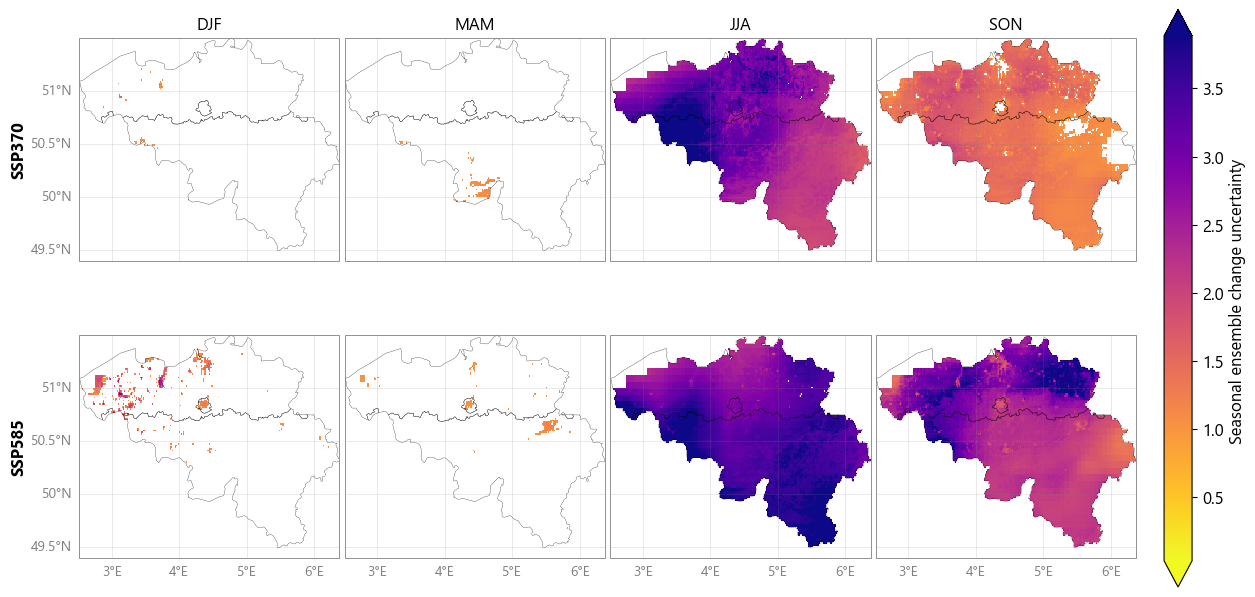

In [215]:
scenarios = ['ssp370', 'ssp585']

fig, axes, cb = plot_ensemble_recharge_stats(domain_recharge_stats, scenarios,
                                     seasons, 'snr', 'recharge', be_shp,
                                       cmap='plasma_r', snr_thresh=1.0)

cb.ax.set_ylabel('Seasonal ensemble change uncertainty ', fontsize=12)
#call plt.show()
plt.show()

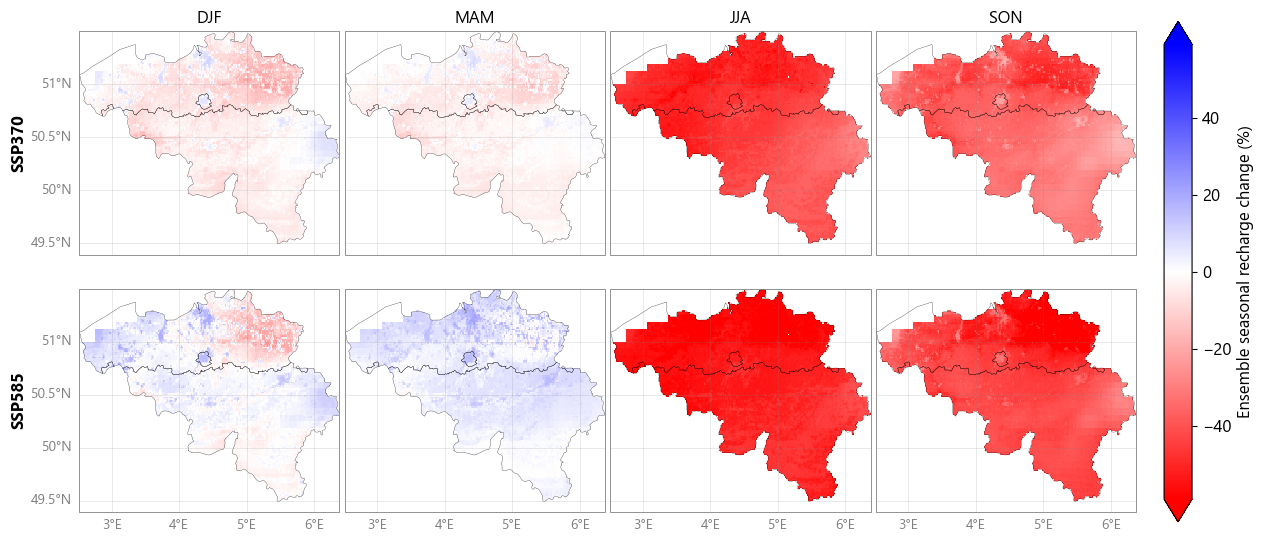

In [213]:
scenarios = ['ssp370', 'ssp585']

fig, axes, cb = plot_ensemble_recharge_stats(domain_recharge_stats, scenarios,
                                     seasons, 'ens_mean', 'recharge', be_shp,
                                       cmap='bwr_r', snr_thresh=10.0)

cb.ax.set_ylabel('Ensemble seasonal recharge change (%)', fontsize=12)
#call plt.show()
plt.show()

##### Internal model variability